# <font color='blue'>Multilayer Perceptron</font>

In [1]:
import numpy as np

class Model:
    def __init__(self):
        self.x = []        
        self.y = []
        self.error = []
        self._x = Input()
        self._y = Input()
        self.nodes = {}
        
    def sequential(self, data_train, data_test):
        self.x = data_train
        self.y = data_test
        
    def dense(self, n_hidden, input_shape):
        # w1
        self.nodes.update({ Input(): np.random.randn(input_shape, n_hidden) })
        # b1
        self.nodes.update({ Input(): np.zeros(n_hidden) })
        
        # w2
        self.nodes.update({ Input(): np.random.randn(n_hidden, 1) })
        # b2
        self.nodes.update({ Input(): np.zeros(1) })
        
        self.init()
        
    def init(self):
        nodes = [*self.nodes]
        
        t1 = Transfer(self._x, nodes[0], nodes[1])
        a = Activation(t1)
        t2 = Transfer(a, nodes[2], nodes[3])
        Error(self._y, t2)
    
    def sgd(self, params, learning_rate = 1e-2):
        for t in params:
            partial = t.gradients[t]
            t.value -= learning_rate * partial
            
    def train(self, epochs, batch_size, steps_per_epoch):
        for i in range(epochs):
            for j in range(steps_per_epoch):
                data_train_batch, data_test_batch = resample(self.x, self.y, n_samples = batch_size)
                self._x.value = data_train_batch
                self._y.value = data_test_batch

                sorted_nodes = sort({**{self._x: self.x}, **{self._y: self.y}, **self.nodes})
                for n in sorted_nodes:
                    n.forward()

                for n in sorted_nodes[::-1]:
                    n.backward()
                self.sgd([*self.nodes])
            self.error.append(float("{:.3f}".format(sorted_nodes[-1].value/steps_per_epoch)))
            
    def test(self, data_train, data_test):
            self._x.value = data_train
            self._y.value = data_test
            sorted_nodes = sort({**{self._x: self.x}, **{self._y: self.y}, **self.nodes})
            for n in sorted_nodes:
                n.forward()
            print(float("{:.3f}".format(sorted_nodes[-1].value/steps_per_epoch)))
            
    def plot(self):
        plt.plot(np.arange(len(self.error)), self.error)
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.show()
        
        
class Node:
    def __init__(self, inputs = []):
        self.inputs = inputs
        self.outputs = []
        self.value = None
        self.gradients = {}
        for n in inputs:
            n.outputs.append(self)

    def forward(self):
        raise NotImplementedError

    def backward(self):
        raise NotImplementedError
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__) 
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self):
        pass

    def backward(self):
        self.gradients = {self: 0}
        for n in self.outputs:
            self.gradients[self] = self.gradients[self] + n.gradients[self]
        pass
    
class Transfer(Node):
    def __init__(self, x, w, b):
        Node.__init__(self, [x, w, b])

    def forward(self):
        x = self.inputs[0].value
        w = self.inputs[1].value
        b = self.inputs[2].value
        self.value = np.dot(x, w) + b

    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            # x
            self.gradients[self.inputs[0]] = self.gradients[self.inputs[0]] + np.dot(n.gradients[self], self.inputs[1].value.T)
            # w
            self.gradients[self.inputs[1]] = self.gradients[self.inputs[1]] + np.dot(self.inputs[0].value.T, n.gradients[self])
            # b
            self.gradients[self.inputs[2]] = self.gradients[self.inputs[2]] + np.sum(n.gradients[self], axis = 0, keepdims = False)
            
class Activation(Node):
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-z))
    
    def forward(self):
        self.value = self._sigmoid(self.inputs[0].value)

    def backward(self):
        ## self.inputs == Tranfer Object
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            sigmoid = self.value
            self.gradients[self.inputs[0]] = self.gradients[self.inputs[0]] + sigmoid * (1 - sigmoid) * n.gradients[self]

    
class Error(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
   
    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        self.value = np.mean((y - a)**2)
        self.m = y.shape[0]
        self.diff = y - a
        
        
    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
        
# using kahn's algorithm
def sort(data):
    #get the input class nodes
    inputs = [n for n in data.keys()]
    nodes = [n for n in inputs]
    queue = {}
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in queue:
            queue[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in queue:
                queue[m] = {'in': set(), 'out': set()}
            queue[n]['out'].add(m)
            queue[m]['in'].add(n)
            nodes.append(m)
    G = []
    TS = set(inputs)
    while len(TS) > 0:
        n = TS.pop()

        if isinstance(n, Input):
            n.value = data[n]

        G.append(n)
        for m in n.outputs:
            queue[n]['out'].remove(m)
            queue[m]['in'].remove(n)
            if len(queue[m]['in']) == 0:
                TS.add(m)
    return G


0.24


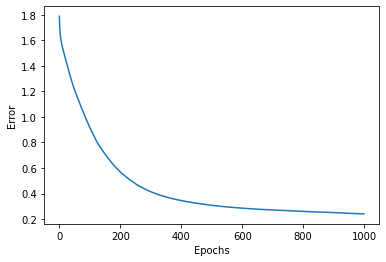

In [2]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = load_boston()

data_train = data['data']
data_test = data['target']

data_train = (data_train - np.mean(data_train, axis = 0)) / np.std(data_train, axis = 0)

x, _x = train_test_split(data_train, test_size=0.2)
y, _y = train_test_split(data_test, test_size=0.2)

input_shape = x.shape[1]
n_hidden = 20
epochs = 1000
m = data_train.shape[0]
batch_size = 11
steps_per_epoch = m // batch_size

model = Model()
model.sequential(x, y)
model.dense(n_hidden, input_shape)
model.train(epochs, batch_size, steps_per_epoch)
model.test(_x, _y)
model.plot()
